In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, PoissonRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing 

import regressionUtils as rg


In [2]:
county_df = pd.read_pickle("../Data/county_data_totals.pkl")
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3087 entries, 1001.0 to 56045.0
Data columns (total 65 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3087 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3087 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3087 non-null   float64
 3   Population, Census, April 1, 2010                                                       3087 non-null   float64
 4   Persons under 5 years, percent                                                          3086 non-null   float64
 5   Persons under 18 years, percent                            

In [3]:
county_df.drop(county_df[county_df['deaths'] == 0].index, inplace = True) 
county_df['Deaths per 100k'] = 1e5*county_df['deaths']/county_df['Population estimates, July 1, 2019,  (V2019)']
pt_boxcox = preprocessing.PowerTransformer(method='box-cox', standardize=True)
county_df['Deaths per 100k, trans'] = pt_boxcox.fit_transform(county_df[['Deaths per 100k']])
# county_df['Deaths per 100k, trans'] = county_df['Deaths per 100k'] # comment this in instead of the above to not do the box cox transform (for plots showing it's use)


In [4]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3007 entries, 1001.0 to 56045.0
Data columns (total 67 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3007 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3007 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3007 non-null   float64
 3   Population, Census, April 1, 2010                                                       3007 non-null   float64
 4   Persons under 5 years, percent                                                          3007 non-null   float64
 5   Persons under 18 years, percent                            

In [5]:
# main_features_df = county_df[["Black or African American alone, percent(a)", "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019", \
#                               "Persons  without health insurance, under age 65 years, percent", "Households with a broadband Internet subscription, percent, 2015-2019", \
#                               "Median value of owner-occupied housing units, 2015-2019", \
#                               "Deaths per 100k, trans"]].dropna()

main_features_df = county_df[[\
#                             no    "Persons under 5 years, percent",\
                              "Persons 65 years and over, percent",\
#                             no    "White alone, percent",\
                                "Black or African American alone, percent(a)",\
#                             no    "Asian alone, percent(a)",\
                                "Two or More Races, percent",\
                                "White alone, not Hispanic or Latino, percent",\
                                "Median value of owner-occupied housing units, 2015-2019",\
#                             no    "Median gross rent, 2015-2019",\
                                "Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019",\
                                "Households with a computer, percent, 2015-2019",\
                                "Households with a broadband Internet subscription, percent, 2015-2019",
                                "High school graduate or higher, percent of persons age 25 years+, 2015-2019",\
                                "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019",\
                                "Persons  without health insurance, under age 65 years, percent",\
                                "Median household income (in 2019 dollars), 2015-2019",\
                                "Deaths per 100k, trans"]].dropna()





main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3004 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           3004 non-null   float64
 1   Black or African American alone, percent(a)                                  3004 non-null   float64
 2   Two or More Races, percent                                                   3004 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 3004 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      3004 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   3004 non-null   float64
 6   Households with a computer, pe

In [6]:
# drop some outliers
main_features_df.drop(main_features_df[main_features_df['Two or More Races, percent'] > 20].index, inplace = True) 
main_features_df.drop(main_features_df[main_features_df['Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019'] < 70].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['High school graduate or higher, percent of persons age 25 years+, 2015-2019'] < 50].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['Median value of owner-occupied housing units, 2015-2019'] > 0.8e6].index, inplace = True) 
main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2988 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           2988 non-null   float64
 1   Black or African American alone, percent(a)                                  2988 non-null   float64
 2   Two or More Races, percent                                                   2988 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 2988 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      2988 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   2988 non-null   float64
 6   Households with a computer, pe

In [7]:
#sns.heatmap(main_features_df.corr(), cmap="seismic", vmin=-1, vmax=1);

In [8]:
# pp = sns.pairplot(main_features_df, plot_kws=dict(alpha=.1, edgecolor='none'))
# for ax in pp.axes.flatten():
#     ax.set_xlabel(ax.get_xlabel(), rotation = 5)
#     ax.set_ylabel(ax.get_ylabel(), rotation = 85)
##     ax.yaxis.get_label().set_horizontalalignment('right')    

In [9]:
X, y = main_features_df.drop('Deaths per 100k, trans',axis=1), main_features_df['Deaths per 100k, trans']
input_features = list(X.columns)

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=110) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

Simple regression scores:  [0.241, 0.268, 0.238, 0.289, 0.267] 

Simple mean cv r^2: 0.261 +- 0.019 

Simple regression coef:  [ 1.66284414e-02 -3.55427534e-03 -2.04275406e-01 -1.70960411e-02
 -3.66573030e-06  7.76273197e-05 -3.40688405e-02  4.28558659e-03
  1.47747187e-02 -7.03352287e-03  9.61963152e-03  1.23217121e-05] 



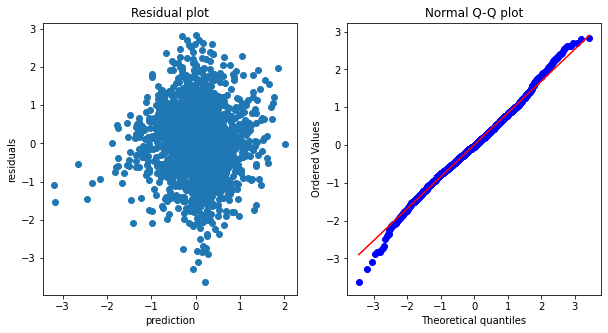

In [10]:
rg.doSimpleLinearRegression(X, y, input_features)

Poly scores:  [0.283, 0.321, 0.339, 0.315, 0.316] 

Poly mean cv r^2: 0.315 +- 0.018 

Poly coef:  [-1.49168122e-07 -9.50173161e-02  5.45799658e-02 -1.28545855e+00
  1.06689198e-01  6.80106732e-07 -2.74529861e-01 -7.59978024e-02
  8.14993350e-02 -2.66142828e-02  2.15127750e-01  3.38578525e-01
 -8.68904595e-05 -9.07235620e-04 -1.00134500e-03 -1.63910805e-02
  6.48785097e-04  3.12687686e-08 -9.28158709e-04  1.11287403e-03
  8.24171926e-04  1.25538389e-03 -1.89439081e-03  5.37527388e-04
 -3.42380667e-07  7.44167422e-05 -6.13048696e-03  1.35036342e-04
  7.97445577e-08 -1.24647138e-05 -2.67522249e-04  4.72111368e-04
 -2.74324125e-04 -2.23455903e-04 -7.56627135e-04 -6.01282372e-07
  5.05946459e-03  1.13277344e-03 -2.19876680e-07  1.20492584e-02
 -4.49404857e-03  7.05130249e-03  4.03164560e-03 -2.78212857e-04
 -1.64628872e-03 -3.85137439e-06 -2.94467188e-04 -7.98347332e-08
 -7.55534187e-04 -5.78904420e-04  5.94505558e-05 -2.76047002e-05
 -7.24726480e-05  6.02097773e-04  2.74106050e-07 -6.3374

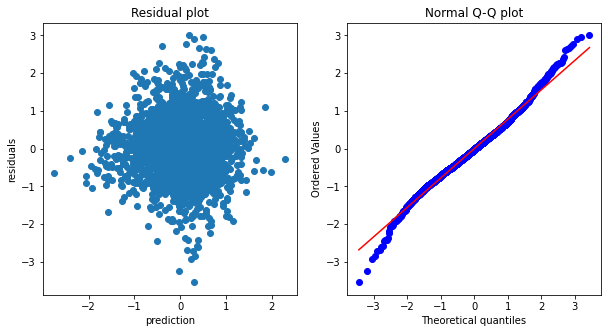

In [11]:
rg.doPolynomialRegression(X, y, input_features)

In [12]:
rg.doLassoCV(X,y)

LassoCV simple regression score:  0.269 

LassoCV simple alpha:  0.0014057540825200062 

LassoCV simple coef:  [ 0.07433218 -0.04729389 -0.22784183 -0.32740916 -0.32204395  0.00199969
 -0.19282177  0.01902547  0.08361017 -0.05711893  0.04456138  0.16139393] 



In [13]:
rg.doLassoCV(X,y,True)

/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19390571175108562, tolerance: 0.1874379373230216
  model = cd_fast.enet_coordinate_descent_gram(
/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24327671334140177, tolerance: 0.1874379373230216
  model = cd_fast.enet_coordinate_descent_gram(
/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23352813074097867, tolerance: 0.1874379373230216
  model = cd_fast.enet_coordinate_descent_gram(
/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklear

LassoCV poly regression score:  0.364 

LassoCV poly alpha:  0.0004380803764332246 

LassoCV poly coef:  [ 0.          0.          0.         -0.          0.0488612  -0.
 -0.00572578  0.         -0.          0.          0.10757055  0.47876174
  0.         -0.07870904 -0.28126554 -0.25556437  0.30223805 -0.08642164
 -0.5147027   0.6288655   0.04221985  0.         -0.20101555 -0.06831062
  0.10475715  0.         -0.19282461  0.05422385  0.10998472  0.36739677
  0.33757406  0.01917946 -0.         -0.02674034 -0.14154927 -0.36373374
  0.02254795  0.08770748 -0.12616184  0.06292666 -0.          0.09013342
 -0.         -0.         -0.08120239 -0.14114755 -0.66289804 -0.52694266
 -0.08013044 -0.         -0.19936962  0.17596471 -0.          0.24421372
  0.17621214 -0.26781699 -0.         -1.09658304  1.08616075 -0.10221942
  1.05144922 -0.01681297 -0.          0.03486213 -0.         -0.10321566
 -0.13948865  0.32567352  0.          0.78122945 -0.53631255 -0.24497971
  0.49976142 -0.          0

/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.840405711054245, tolerance: 0.23306444872256543
  model = cd_fast.enet_coordinate_descent(


In [14]:
rg.doRidgeCV(X,y)

RidgeCV simple regression score:  0.269 

RidgeCV simple alpha:  10.0 

RidgeCV simple coef:  [ 0.0750525  -0.04890042 -0.22911927 -0.33100218 -0.32088502  0.00220414
 -0.20513362  0.03199081  0.08978402 -0.06331978  0.04878459  0.16369216] 



In [15]:
rg.doRidgeCV(X,y,True)

RidgeCV poly regression score:  0.369 

RidgeCV poly alpha:  1.0 

RidgeCV poly coef:  [ 0.          0.0734168   0.24778784 -0.58231355  0.5905935  -0.31493595
 -0.50637902  0.16711936 -0.09699244  0.0483996   0.46843109  0.59435499
  0.04145039 -0.10869581 -0.31690198 -0.31645573  0.27636064 -0.03728049
 -0.54485279  0.51094888  0.20218754  0.05812517 -0.25832621 -0.06197699
  0.0430764   0.02277139 -0.18292377  0.08102728  0.15477343  0.29521191
  0.21422676  0.15804451 -0.14383628 -0.08755519 -0.15592366 -0.40843794
  0.04125896  0.10049228 -0.09344529  0.57901786 -0.15929995  0.34162297
  0.04643693 -0.012398   -0.06843035 -0.22124558 -0.66902638 -0.44278957
 -0.44025118 -0.10586358 -0.30113698  0.18649109 -0.15292691  0.23597158
  0.23587893 -0.29821582  0.04195306 -0.61366985  1.01243157 -0.42543259
  1.10301719 -0.01002102  0.04132971  0.67767615  0.01523801 -0.20409152
 -0.33863427  0.50951043 -0.13773717  0.8395093  -0.54582008 -0.59725099
  0.68482845 -0.48205605  0.13114059 